# Emulator Evaluation

In this notebook, we reproduce the one-one plots and statistical analysis evaluating the performance of the emulators. 

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import pandas as pd
import xarray as xr

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='ticks', context='talk')

SAVEFIGS = False

/Users/daniel/anaconda/lib/python3.4/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


## LHS Sampling

### Load the dataset

The sampling results were previously saved as CSV tables, with each row representing one sample set. Separately, a corresponding table saved the experimental design (input parameters) for each sample set. In order to read in the results, we need to read *both* files. We could join them on a common index, but the sampling results have already been reshaped into a "tidy" format, melting over the parameterization name. The `sample_id` column can be used as a join index if desired.

In [3]:
DATA_DIR = "../MARC_pcm_evaluation/data/"

def get_data(exp, data_dir=DATA_DIR):
    # Open and read the HDF5 file using the HDFStore/PyTables API
    store = pd.HDFStore(data_dir+"MARC_{}_sampling_data.h5".format(exp))
    results = store['results']
    design = store['design']
    store.close()
    
    
    # Pivot results so that the sample_id and variable are indices
    results = results.pivot_table("value", 
                                  index=["sample_id", "variable"], 
                                  columns="scheme")
        
    # log10 -> decimal
    results = np.power(10., results)
    
    # Merge on common sample_id index
    combined = (
        design
        .join(results, how='inner')
        .reorder_levels(['variable', 'sample_id'])
        .sortlevel()
    )
    
    # Calculate V from logV
    combined['V'] = np.power(10., combined['logV'])
    
    return combined

This cell quickly creates a four-panel layout of one-one plots outlining the performance of each of the emulators and activation schemes. 

0 gCCN_3
1 gCCN_4
2 ARG
3 MBN


/Users/daniel/anaconda/lib/python3.4/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


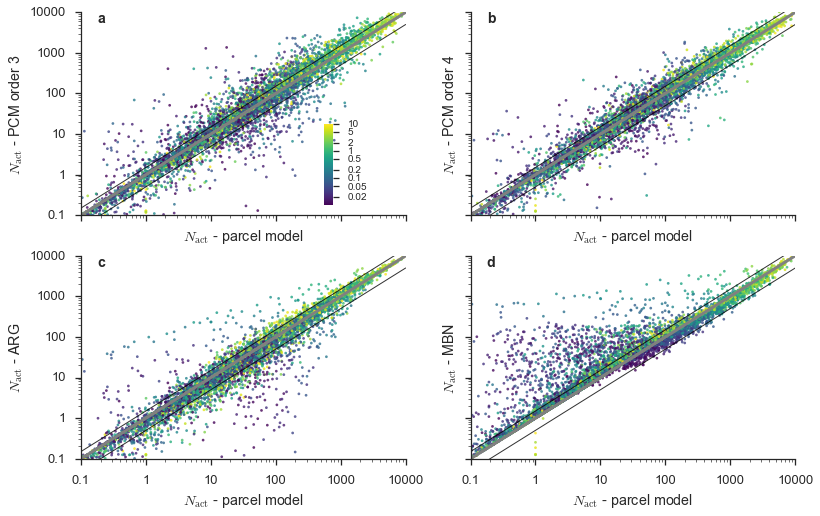

In [4]:
from eval_util import plot_oneone
import string

exp = "gCCN"
# variable = "Smax"
# variable_str = "$S_\mathrm{max}$"
# variable_lims = (1e-3, 1.)
variable = "Nderiv"
variable_str = "$N_\mathrm{act}$"
variable_lims = (1e-1, 1e4)

data = get_data(exp)
V = data.loc[variable, 'V']
parcel = data.loc[variable, 'parcel']

size = 4.
aspect= 16./10.
ncol, nrow = 2, 2
width, height = size*aspect*ncol, size*nrow

v_ticks = [0.02, 0.05, 0.1, 0.2, 0.5, 1.0, 2.0, 5.0, 10.0]
oneone_kws = dict(color_ticks=v_ticks, color_bar=True, color_data=V,
                  var_label=variable_str, lims=variable_lims)

fig, axs = plt.subplots(nrow, ncol, figsize=(width, height),
                        sharex=True, sharey=True)

for i, (ax, scheme) in enumerate(zip(axs.flat, 
                                     [exp+"_3", exp+"_4", 
                                      "ARG", "MBN"])):
    print(i, scheme)
    letter = string.ascii_lowercase[i]
    
    param = data.loc[variable, scheme]
    scheme_kws = oneone_kws.copy()
    if scheme.startswith(exp):
        scheme_kws['param_label'] = "PCM order {}".format(scheme[-1])
    else:
        scheme_kws['param_label'] = scheme
    if i > 0:
        scheme_kws['color_bar'] = False
    scheme_kws['ax'] = ax

    _, ax = plot_oneone(parcel, param, **scheme_kws)
    
    ax.text(0.05, 0.95, letter, fontsize=14, fontweight='bold',
            transform=ax.transAxes)

if SAVEFIGS:
    fn = "figs/{}_{}_oneone_4panel".format(variable, exp)
    plt.savefig(fn+".pdf", dpi=200, rasterized=True, bbox_inches='tight')
    plt.savefig(fn+".png", dpi=200, bbox_inches='tight')

Retrieve and print the summary statistics tables.

In [198]:
DATA_DIR = "../MARC_pcm_evaluation/data/"
pd.set_option('precision', 2)

def get_stats(exp, data_dir=DATA_DIR,
              result='Smax', scaling='normal'):
    stats_fn = DATA_DIR+"MARC_{}_stats.p".format(exp)
    stats = (
        pd
        .read_pickle(stats_fn)
        .unstack()
    )
    # Idx levels = result, scaling, stat, scheme
    stats = stats.loc[(result, scaling)]
    stats.name = result
    
    stats = (
        stats
        .reset_index()
        .pivot('scheme', 'stat')
    )
    
    return stats

uleft = get_stats("main", result="Smax", scaling='log10')
uright = get_stats("main", result="Nderiv_Neq", scaling='normal')
usummary = pd.concat([uleft, uright], axis=1)

lleft = get_stats("gCCN", result="Smax", scaling='log10')
lright = get_stats("gCCN", result="Nderiv_Neq", scaling='normal')
lsummary = pd.concat([lleft, lright], axis=1)


/Users/daniel/anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:13: PerformanceWarning: indexing past lexsort depth may impact performance.


In [199]:
usummary['exp'] = "main"
lsummary['exp'] = "gCCN"

usummary = usummary.reset_index().set_index(["exp", 'scheme'])
lsummary = lsummary.reset_index().set_index(["exp", 'scheme'])

In [200]:
summary = pd.concat([usummary, lsummary])

In [201]:
summary

Smax                                  Nderiv_Neq                 \
stat          mae    mre mre_std nrmse    r2  rmse        mae    mre mre_std   
exp  scheme                                                                    
main ARG     0.18  -3.26   40.61  0.10  0.94  0.24      40.14  25.39   80.35   
     MBN     0.20 -11.79   34.28  0.18  0.81  0.42      59.05  44.95  127.35   
     main_3  0.16   0.59   33.08  0.09  0.95  0.20      72.54   9.20   81.56   
     main_4  0.10  -0.60   30.28  0.06  0.98  0.13      45.47   8.89   66.81   
gCCN ARG     0.17   8.54   28.64  0.09  0.93  0.23      37.41  -3.92   47.48   
     MBN     0.20  -9.58   17.50  0.17  0.78  0.41      56.03  33.30  111.58   
     gCCN_3  0.16   0.59   22.37  0.08  0.95  0.21      81.19  15.14   79.25   
     gCCN_4  0.10   0.36   19.89  0.06  0.98  0.14      50.99   6.90   58.19   

                                 
stat        nrmse    r2    rmse  
exp  scheme                      
main ARG     0.15  0.98  127.52  
     MBN     0.30  0.90  256.79  
     main_3  0.31  0.90  264.40  
     main_4  0.19  0.96  166.56  
gCCN ARG     0.15  0.98  127.63  
     MBN     0.31  0.89  271.81  
     gCCN_3  0.34  0.87  296.42  
     gCCN_4  0.23  0.94  198.64

In [8]:
table = (
     summary
     .rename(
        index={
        "main_3": "PCM Order 3", "main_4": "PCM Order 4",
        "gCCN_3": "PCM Order 3", "gCCN_4": "PCM Order 4",
        },
        columns={
        "Smax": "$\log_{10}S_\mathrm{max}$", 
        "Nderiv_Neq": "$N_\mathrm{act}$",
        "mae": "MAE", "mre": "MRE", "r2": "$r^2$", 
        "nrmse": "NRMSE"
        }
     )
     .drop(["mre_std", "rmse"], axis=1, level=1)
)
print(table.to_latex(escape=False))

\begin{tabular}{llrrrrrrrr}
\toprule
     &     & $\log_{10}S_\mathrm{max}$ &        &       &       & $N_\mathrm{act}$ &        &       &       \\
     &     &                       MAE &    MRE & NRMSE & $r^2$ &              MAE &    MRE & NRMSE & $r^2$ \\
exp & scheme &                           &        &       &       &                  &        &       &       \\
\midrule
main & ARG &                      0.18 &  -3.26 &  0.10 &  0.94 &            40.14 &  25.39 &  0.15 &  0.98 \\
     & MBN &                      0.20 & -11.79 &  0.18 &  0.81 &            59.05 &  44.95 &  0.30 &  0.90 \\
     & PCM Order 3 &                      0.16 &   0.59 &  0.09 &  0.95 &            72.54 &   9.20 &  0.31 &  0.90 \\
     & PCM Order 4 &                      0.10 &  -0.60 &  0.06 &  0.98 &            45.47 &   8.89 &  0.19 &  0.96 \\
gCCN & ARG &                      0.17 &   8.54 &  0.09 &  0.93 &            37.41 &  -3.92 &  0.15 &  0.98 \\
     & MBN &                      0.20 &  -9.58 

---

## MARC Aerosol Sampling

Separately, we also assessed parameterization performance using a random draw of samples taken from an online MARC simulation. We took one set of $n=10000$ samples and ran all of our parameterizations against it. This includes running the **MARC_main** emulator using the same samples as what we generated for the **MARC_gCCN** scheme.

### Load the dataset

As before, we load the datasets which are saved in an HDF5 file on disk. The results and design parameters were stored separately, so we'll do some quick re-indexing to merge everything back together. We'll also QC the data by dropping any simulations that failed (had `inf` or `nan` results). That ends up being a tiny number of simulations, so we won't worry about them.

In [4]:
DATA_DIR = "../MARC_pcm_evaluation/data/"
store = pd.HDFStore(DATA_DIR+"aerosol_data.h5")
results = store['results']
design = store['design']
store.close()

print(results.head())

# Pivot results so that the sample_id and variable are indices
results = (
    results
    .set_index(['sample_id', 'variable'])
    .sortlevel()
    .pivot(columns='scheme')
    ['value']
)

# Filter inf, bad value
results = (
    results
    .replace([np.inf, -np.inf], np.nan)
    .dropna()
)

# log10 -> decimal
results = np.power(10., results)

# Merge on common sample_id index
combined = (
    design
    .join(results, how='inner')
    .reorder_levels(['variable', 'sample_id'])
    .sortlevel()
)

# Calculate V from logV
combined['V'] = np.power(10., combined['logV'])

   scheme  sample_id variable    value
0  parcel          0     Smax -2.47115
1  parcel          1     Smax -2.50318
2  parcel          2     Smax -3.13706
3  parcel          3     Smax  -2.5914
4  parcel          4     Smax  -2.3702


Just as a test, we can now directly do one-one comparison plots. That won't be the focus here, however.

Index(['Unnamed: 0', 'lat', 'lev', 'lon', 'time', 'logN_ACC', 'logN_MOS',
       'logN_MBS', 'logN_DST01', 'logN_DST02', 'logN_SSLT01', 'logmu_ACC',
       'logmu_MOS', 'logmu_MBS', 'kappa_MOS', 'Q', 'P', 'T', 'logV', 'ORO',
       'ARG', 'MBN', 'gCCN_3', 'gCCN_4', 'main_3', 'main_4', 'parcel', 'V'],
      dtype='object')


/Users/daniel/anaconda/lib/python3.4/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


(<matplotlib.figure.Figure at 0x111986ac8>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1146fcdd8>)

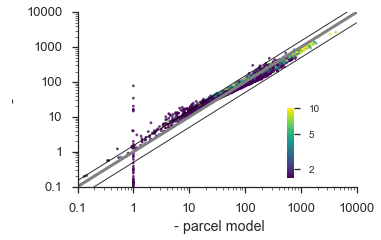

In [5]:
from eval_util import plot_oneone

x = combined.loc['Nderiv']
print(x.columns)

plot_oneone(x['parcel'], x['MBN'], '', '',
            np.power(10., x['V']), color_bar=True, 
            color_ticks=[0.02, 0.05, 0.1, 0.2, 0.5, 1., 2., 5., 10.],
            lims=(1e-1, 1e4))


Iterating through the various combinations, we note that the **main_4** scheme grossly outperforms the **gCCN** schemes and compares favorably with both the ARG and MBN schemes. Really, the **gCCN** scheme can significantly under-predict the droplet number concentration in some scenarios.

How does the distribution of the design parameters from these samples compare to our assumed bounds? We can plot the distribution for each term, and denote those bounds on the same chart for quick comparison.

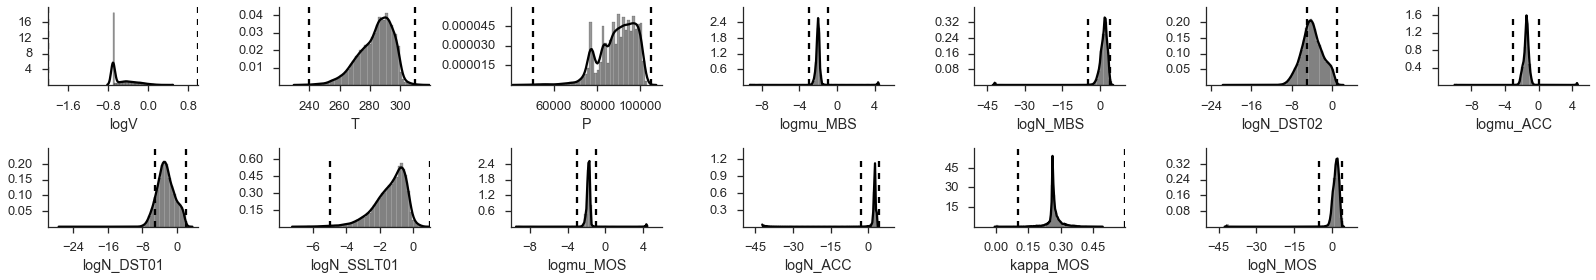

In [13]:
from matplotlib.ticker import MaxNLocator

var_bnds = {
    'logN_ACC': [-3, 4], 'logN_MOS': [-5, 4], 'logN_MBS': [-5, 4],
    'logN_DST01': [-5, 2], 'logN_DST02': [-5, 1], 'logN_SSLT01': [-5, 1],
    'logmu_ACC': [-3, 0], 'logmu_MOS': [-3, -1], 'logmu_MBS': [-3, -1],
    'kappa_MOS': [0.1, 0.6], 'logV': [-2, 1], 'T': [240, 310], 'P': [50000, 105000]
}

keys = list(var_bnds.keys())
subset = combined.loc['Smax'][keys]

size = 2.
aspect = 16./10.
nrows, ncols = 3, 7
width = ncols*size*aspect
height = nrows*size

fig, axes = plt.subplots(nrows, ncols, figsize=(width,height))

for ax, key in zip(axes.flat, keys):
    sns.distplot(subset[key], hist=True, kde=True, color='k',
                 ax=ax)
    lo, hi = var_bnds[key]
    ymin, ymax = ax.get_ylim()
    ax.vlines([lo, hi], ymin, ymax, linestyle='dashed')
    ax.set_xlabel(key)
    ax.xaxis.set_major_locator(MaxNLocator(nbins=5, prune='both'))
    ax.yaxis.set_major_locator(MaxNLocator(nbins=5, prune='both'))
    
plt.tight_layout()
sns.despine(fig)

axes.flatten()[-1].set_visible(False)
plt.savefig("figs/MARC_parameter_dists.pdf", bbox_inches='tight', transparent=True)

Does it matter if a parameter set is fully inside the boundaries used to construct the emulators? We can very easily check this by partitioning the dataset using a masking function, and plotting distributions of relative error for a given term.

In [12]:
cond = True
for key in keys:
    lo, hi = var_bnds[key]
    cond = cond & (lo <= subset[key]) & (hi >= subset[key])
    
x = combined.loc['Nderiv']
x = x.assign(in_bounds=False)
x.loc[cond, 'in_bounds'] = True

# Compute relative errors
def _rel_err(x, y):
    return 100.*(x-y)/y
schemes = ['ARG', 'MBN', 'main_3', 'main_4', 'gCCN_3', 'gCCN_4']
data = {}
for scheme in schemes:
    data[scheme] = _rel_err(x[scheme], x['parcel'])
data['in_bounds'] = x['in_bounds']
df_err = pd.DataFrame(data, index=x.index)

# Convert into tidy dataset
df_err_tidy = (
    pd
    .melt(df_err, id_vars='in_bounds', value_vars=schemes)
    .replace([np.inf, -np.inf, np.nan], np.nan)
    .dropna(subset=['value', ])
)
df_err_tidy = df_err_tidy[(df_err_tidy.value > -50) &
                          (df_err_tidy.value < 50)    ]


/Users/daniel/anaconda/lib/python3.4/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


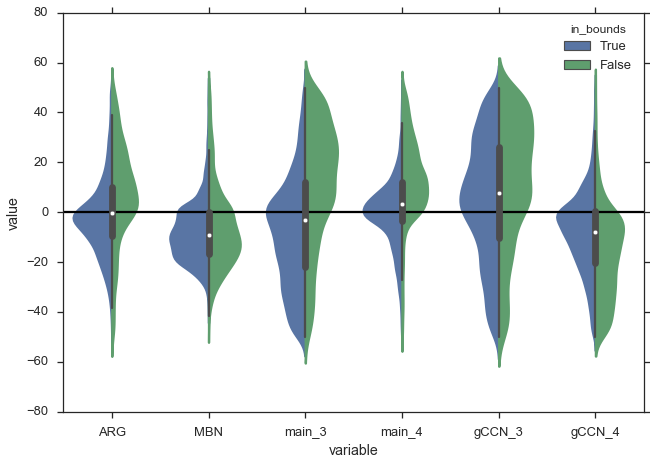

In [13]:
ax = sns.violinplot(data=df_err_tidy, x='variable', y='value', hue='in_bounds', split=True)
ax.hlines(0, *ax.get_xlim())

### Total N vs in-bounds

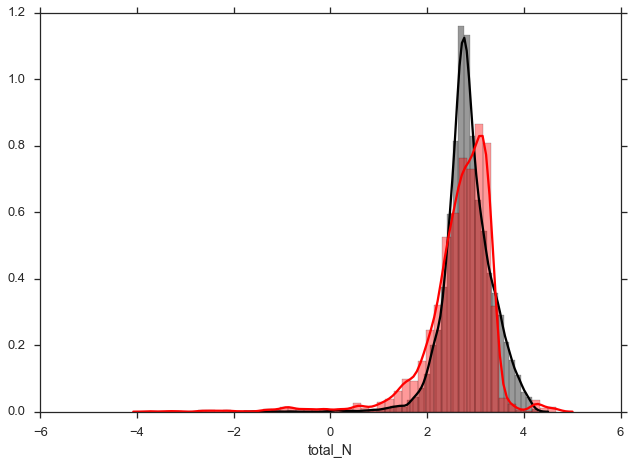

In [14]:
total_N = (
    subset
    .filter(axis=1, regex="logN") # choose logN columns
    .pipe(lambda x: 10.**x)
    .sum(axis=1)
    .pipe(lambda x: np.log10(x))
)
df = subset.copy()
df['total_N'] = total_N
df['in_bounds'] = x.in_bounds
df['oro']= combined.loc['Nderiv', 'ORO']
df = df[(df.oro == 1) | (df.oro == 0)]

df = df.dropna()

sns.distplot(df.loc[df.in_bounds == True, 'total_N'], color='k', label='in bounds')
sns.distplot(df.loc[df.in_bounds == False, 'total_N'], color='r', label='out of bounds')

Generally speaking, the error for the in-bounds parameter sets is *lower* than the out-of-bounds ones. The exception here is with the MBN scheme. Now, the intuition here is that the out-of-bounds scenarios all have very low dust number concentration. However, what do the other parameters look like in the out-of-bounds scenarios?

/Users/daniel/anaconda/lib/python3.4/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


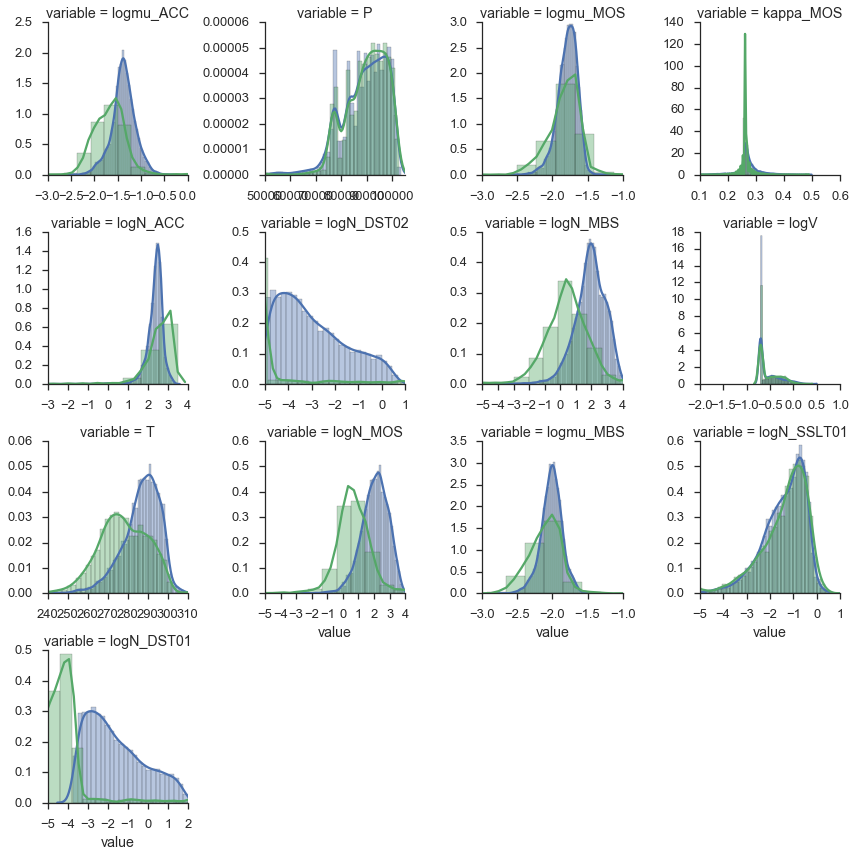

In [15]:
y = subset[keys]
y = y.assign(in_bounds=False)
y.loc[cond, 'in_bounds'] = True

y = pd.melt(y, id_vars='in_bounds', value_vars=keys)

g = sns.FacetGrid(y, col='variable', hue="in_bounds", col_wrap=4,
                  sharex=False, sharey=False)
g.map(sns.distplot, 'value')

for ax, col in zip(g.axes.flat, g.col_names):
    lo, hi = var_bnds[col]
    ax.set_xlim(lo, hi)

This is somewhat surprising. The meteorology parameters aren't really any different, except for temperature. Overall, though the biggest difference is that there are fewer mixed-mode particles (and they're potentially smaller) in the out-of-bounds cases - but still well within the boundaries we used to build the emulators!

/Users/daniel/anaconda/lib/python3.4/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


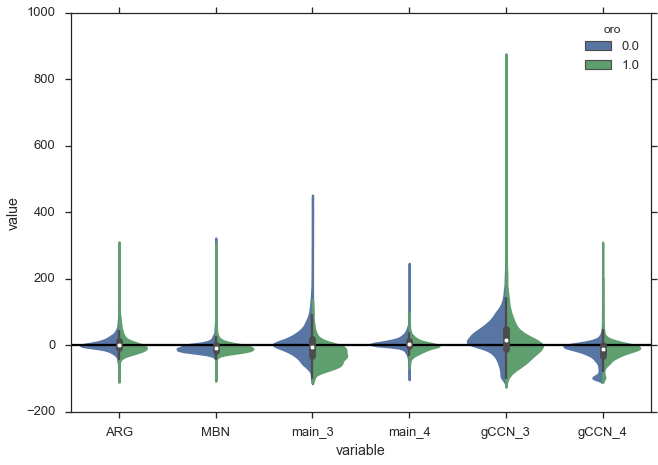

In [16]:
oro = combined.loc['Nderiv', 'ORO']
dff = df_err.copy()
dff['oro'] = oro

dff = (
    pd
    .melt(dff, id_vars='oro', value_vars=schemes)
    .replace([np.inf, -np.inf, np.nan], np.nan)
    .dropna(subset=['value', ])
)
dff = dff[(dff.oro == 1) | (dff.oro == 0)]
dff[dff.value > 1000] = np.nan
dff.dropna(inplace=True)

ax = sns.violinplot(data=dff, x='variable', y='value', hue='oro',
                    split=True)
ax.hlines(0, *ax.get_xlim())

### Relative Error vs Oro

Rather than repeat a tableau of one-one plots, we can present error metrics for the MARC sampling experiments using relative error, breaking down by different orographic regimes.

In [17]:
cond = True
for key in keys:
    lo, hi = var_bnds[key]
    cond = cond & (lo <= subset[key]) & (hi >= subset[key])
    
v = 'Nderiv'
x = combined.loc[v]
x = x.assign(in_bounds=False)
x.loc[cond, 'in_bounds'] = True

# Compute relative errors
def _rel_err(x, y):
    return 100.*(x-y)/y
schemes = ['ARG', 'MBN', 'main_3', 'main_4', 'gCCN_3', 'gCCN_4']
data = {}
for scheme in schemes:
    data[scheme] = _rel_err(x[scheme], x['parcel'])
data['in_bounds'] = x['in_bounds']
df_err = pd.DataFrame(data, index=x.index)

df_err['oro'] = combined.loc[v, 'ORO']
df_err = df_err[(df_err.oro == 1) | (df_err.oro == 0)]

In [18]:
# Convert into tidy dataset
df_err_tidy = (
    pd
    .melt(df_err, id_vars=['in_bounds', 'oro'], value_vars=schemes)
    .replace([np.inf, -np.inf, np.nan], np.nan)
    .dropna(subset=['value', ])
)
df_err_tidy = df_err_tidy[(df_err_tidy.value > -150) &
                          (df_err_tidy.value < 150)    ]
df_err_tidy = df_err_tidy.replace({'oro': {0: 'ocean', 1: 'land'}})

/Users/daniel/anaconda/lib/python3.4/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
/Users/daniel/anaconda/lib/python3.4/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


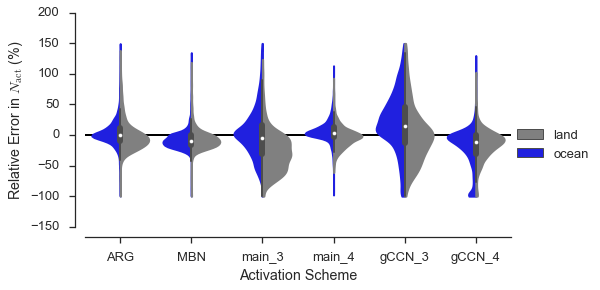

In [19]:
size = 4
aspect = 18./10.
width = size*aspect
height = size
sns.set(style='ticks', context='talk')

g = sns.FacetGrid(df_err_tidy, size=size, aspect=aspect)
g.map(sns.violinplot,"variable", "value", "oro", split=True, scale='width',
      inner='box', cut=0., palette=dict(ocean='blue', land='gray'),
      edgecolor='k', linewidth=2)
g.add_legend(title="")
g.set_axis_labels("Activation Scheme", "Relative Error in $N_\mathrm{act}$ (%)")
sns.despine(fig=g.fig, offset=10)

ax = g.ax
ax.hlines(0, -1, 6, lw=2, zorder=-99)


fn = "figs/MARC_sample.rel_err.{}".format(v)
plt.savefig(fn+".pdf", dpi=200, rasterized=True, bbox_inches='tight')
plt.savefig(fn+".png", dpi=200, bbox_inches='tight')

### Relative Error vs logV

In [20]:
df_err['logV'] = x.logV
bins = np.linspace(np.log10(0.19), 0.5, 11)
bin_labels = pd.cut(df_err['logV'], bins)

df_err['bin'] = bin_labels

## PDF of Relative Error

In [14]:
import xarray as xr

v = 'Nderiv'
all_data = combined.loc[v].reset_index()

main_4 4.5891595602008906
gCCN_4 -18.108274251128243
ARG 4.617262787405851
MBN -4.915632155916929


/Users/daniel/anaconda/lib/python3.4/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
/Users/daniel/anaconda/lib/python3.4/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


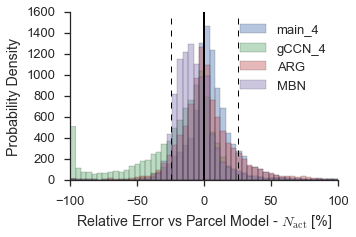

In [51]:
size = 3
aspect = 16./10.
width = size*aspect
height = size

fig, ax = plt.subplots(1, 1, figsize=(width, height))

with sns.color_palette('Dark2', desat=0.):
    for scheme in ['main_4', 'gCCN_4', 'ARG', 'MBN']:
        rel_err = 100.*(all_data[scheme] - all_data['parcel'])/all_data['parcel']
        print(scheme, np.mean(rel_err))
        sns.distplot(rel_err, label=scheme, ax=ax, kde=False,
                     bins=np.linspace(-100., 100., 51))

sns.despine(fig=fig)
ax.set_xlabel("Relative Error vs Parcel Model - $N_\mathrm{act}$ [%]")
ax.set_ylabel("Probability Density")
ax.legend(loc='upper right')
ax.set_xlim(-100., 100.)

ylo, yhi = ax.get_ylim()
ax.vlines(0., ylo, yhi, lw=2, color='k' )
ax.vlines([-25., 25.], ylo, yhi, lw=1, linestyle='dashed', color='k')

plt.savefig("figs/PDF.rel_err.Nact.pdf", transparent=True, bbox_inches='tight')

### Global Distributions of Activation Error

Here, we take the sample dataset and re-project it back onto a geo-gridded dataset.

In [ ]:
glbl = all_data.set_index(['lat', 'lon', 'lev', 'time']).sortlevel()
ds = xr.Dataset.from_dataframe(glbl)

In [189]:
rel_errs = xr.Dataset()
schemes = ['MBN', 'ARG', 'gCCN_4', 'main_4']
for scheme in schemes:
    re = 100.*(ds[scheme] - ds['parcel'])/ds['parcel']
    re = re.mean(['time', 'lev'])
    rel_errs[scheme] = re
rel_errs['parcel'] = ds['parcel'].mean(['time', 'lev'])
rel_errs.lat.attrs.update(dict(standard_name='latitude', long_name='latitude',
                               units='degrees_north', axis='Y'))
rel_errs.lon.attrs.update(dict(standard_name='longitude', long_name='longitude',
                               units='degrees_east', axis='X'))
enc_dict = {scheme: {'_FillValue': -9999} for scheme in schemes}
enc_dict['parcel'] = {'_FillValue': -9999}
nc_fn = "figs/global.rel_err.{}.nc".format(v)
!rm {nc_fn}
rel_errs.to_netcdf(nc_fn, encoding=enc_dict)

This dataset is at our original MARC resolution, but because of our sample size, there are a lot of holes. We can fix this up a bit by coarsening the gridded data, which we do externally via CDO/NCO:

In [190]:
!cdo -remapcon,r80x44 -setctomiss,-9999 {nc_fn} {nc_fn}.temp
!ncks -O -d lat,-60.,60. {nc_fn}.temp {nc_fn}
new_rel_errs = xr.open_dataset(nc_fn)

cdo remapcon: Started child process "setctomiss,-9999 figs/global.rel_err.Nderiv.nc (pipe1.1)".
cdo remapcon: SCRIP first order conservative weights from lonlat (144x64) to lonlat (80x44) grid, with source mask (2926)
cdo remapcon:   0%  0%  1%  2%  3%  4%  5%  6%  7%  8%  9% 10% 11% 12% 13% 14% 15% 16% 17% 18% 19% 20% 21% 22% 23% 24% 25% 26% 27% 28% 29% 30% 31% 32% 33% 34% 35% 36% 37% 38% 39% 40% 41% 42% 43% 44% 45% 46% 47% 48% 49% 50% 51% 52% 53% 54% 55% 56% 57% 58% 59% 60% 61% 62% 63% 64% 65% 66% 67% 68% 69% 70% 71% 72% 73% 74% 75% 76% 77% 78% 79% 80% 81% 82% 83% 84% 85% 86% 87% 88% 89% 90% 91% 92% 93% 94%

In [191]:
import xarray.ufuncs as xu
yy = new_rel_errs.where(new_rel_errs.parcel < 200.)

/Users/daniel/anaconda/lib/python3.4/site-packages/matplotlib/artist.py:221: MatplotlibDeprecationWarning: This has been deprecated in mpl 1.5, please use the
axes property.  A removal date has not been set.
  warnings.warn(_get_axes_msg, mplDeprecation, stacklevel=1)


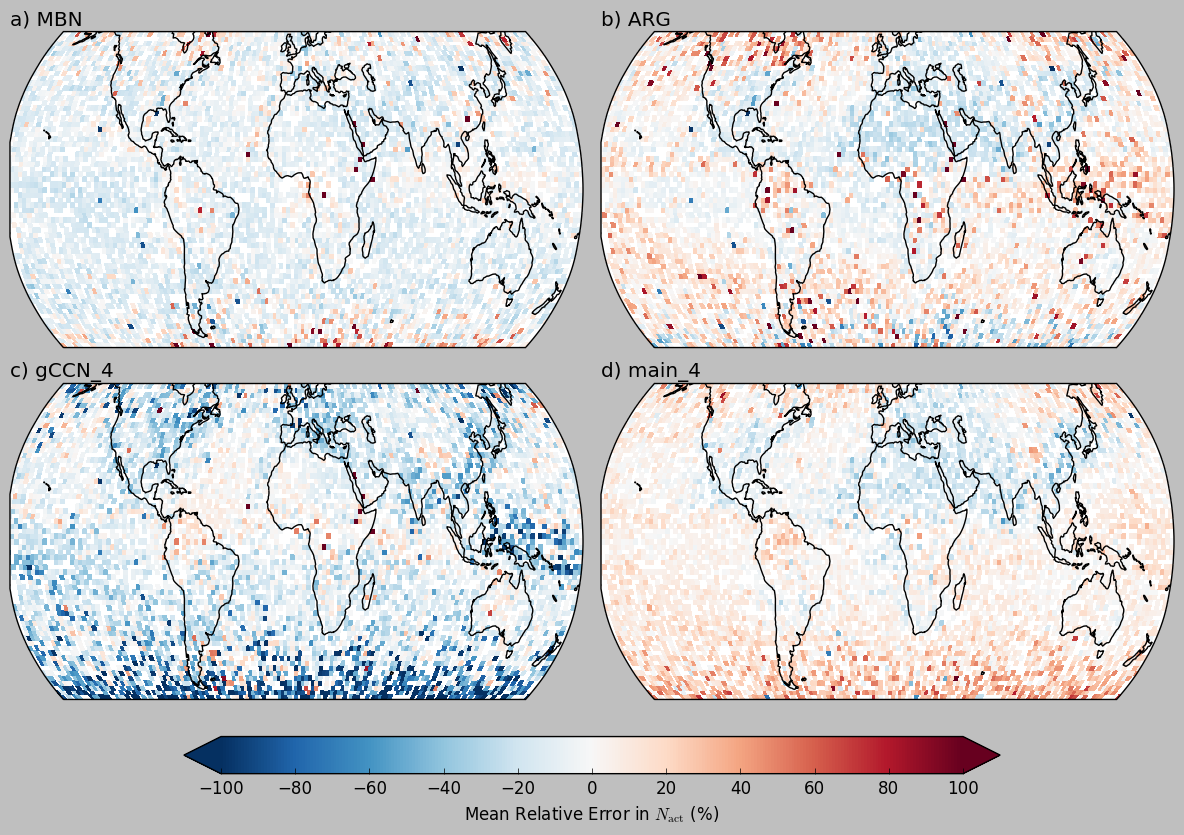

In [194]:
import cartopy.crs as ccrs
import marc_analysis as ma
proj = ccrs.Robinson()

size = 4.
aspect = 1.5
ncols, nrows = 2, 2
width = ncols*size*aspect
height = size*nrows

letters = iter(string.ascii_lowercase)
fig, axes = plt.subplots(nrows, ncols, figsize=(width, height),
                         subplot_kw=dict(aspect='auto', projection=proj))
for ax, scheme in zip(axes.flat, schemes):
    plot_data = ma.plot.cyclic_dataarray(rel_errs[scheme])
    pp = plot_data.plot(x='lon', y='lat', cmap='RdBu_r', extend='both',
                       vmin=-100, vmax=100, ax=ax, transform=ccrs.PlateCarree(),
                       add_colorbar=False)
    ax.coastlines()
    ax.set_title("{}) {}".format(next(letters), scheme), loc='left')
plt.tight_layout()

cb = fig.colorbar(pp, ax=axes.ravel().tolist(), 
                  orientation='horizontal', extend='both', 
                  pad=0.05, fraction=0.05, shrink=0.8)
cb.set_label("Mean Relative Error in $N_\mathrm{act}$ (%)")

fn = "figs/global.rel_err.{}".format(v)
plt.savefig(fn+".pdf", dpi=200, rasterized=True, bbox_inches='tight')
plt.savefig(fn+".png", dpi=200, bbox_inches='tight')

### Summary Table

``` python
uleft = get_stats("main", result="Smax", scaling='log10')
uright = get_stats("main", result="Nderiv_Neq", scaling='normal')
usummary = pd.concat([uleft, uright], axis=1)

lleft = get_stats("gCCN", result="Smax", scaling='log10')
lright = get_stats("gCCN", result="Nderiv_Neq", scaling='normal')
lsummary = pd.concat([lleft, lright], axis=1)
```

In [178]:
import eval_util as eu

schemes = ['ARG', 'MBN', 'main_3', 'main_4', 'gCCN_3', 'gCCN_4']
nas, smaxes = [], []
for scheme in schemes:
    sub = combined.loc['Nderiv', (scheme, 'parcel')]
    sub = eu.clean_df(sub, -1e10, 1e10)
    na_stats = eu.summary_stats(sub[scheme], sub['parcel'])
    na_stats['scheme'] = scheme
    nas.append(na_stats)
    
    sub = np.log10(combined.loc['Smax', (scheme, 'parcel')])
    sub = eu.clean_df(sub, -5, 5)
    smax_stats = eu.summary_stats(sub[scheme], sub['parcel'])
    if scheme == "gCCN_4":
        ddd = sub.copy()
    smax_stats['scheme'] = scheme
    smaxes.append(smax_stats)
    
nas = pd.concat(nas, axis=1).T.set_index('scheme')
nas.columns = pd.MultiIndex.from_product([['Nact',], nas.columns], names=["", "stat"])
smaxes = pd.concat(smaxes, axis=1).T.set_index('scheme')
smaxes.columns = pd.MultiIndex.from_product([['Smax',], smaxes.columns], names=["", "stat"])

summary = pd.concat([smaxes, nas], axis=1)

In [185]:
pd.set_option('precision', 3)

table = (
     summary
     .rename(
        index={
        "main_3": "'main' Order 3", "main_4": "'main' Order 4",
        "gCCN_3": "'gCCN' Order 3", "gCCN_4": "'gCCN' Order 4",
        },
        columns={
        "Smax": "$\log_{10}S_\mathrm{max}$", 
        "Nact": "$N_\mathrm{act}$",
        "mae": "MAE", "mre": "MRE", "r2": "$r^2$", 
        "nrmse": "NRMSE"
        }
     )
     .drop(["mre_std", "rmse"], axis=1, level=1)
)
print(table.to_latex(escape=False))

\begin{tabular}{lllllllll}
\toprule
{} & $\log_{10}S_\mathrm{max}$ &         &         &        & $N_\mathrm{act}$ &       &        &        \\
stat &                       MAE &     MRE &   NRMSE &  $r^2$ &              MAE &   MRE &  NRMSE &  $r^2$ \\
scheme         &                           &         &         &        &                  &       &        &        \\
\midrule
ARG            &                    0.0499 &  -0.155 &  0.0273 &  0.924 &             25.5 &  2.87 &  0.164 &  0.941 \\
MBN            &                     0.055 &  0.0524 &  0.0538 &  0.705 &             26.7 & -6.68 &  0.185 &  0.926 \\
'main' Order 3 &                     0.115 &    0.42 &  0.0775 &   0.33 &             64.7 & -1.81 &  0.435 &  0.589 \\
'main' Order 4 &                    0.0374 &  -0.311 &  0.0198 &  0.956 &               24 &  4.59 &  0.185 &  0.926 \\
'gCCN' Order 3 &                     0.143 &   -1.84 &  0.0851 &  0.182 &             75.6 &  20.9 &  0.472 &  0.516 \\
'gCCN' Order 4 & 

/Users/daniel/anaconda/lib/python3.4/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


-0.18591005006383909

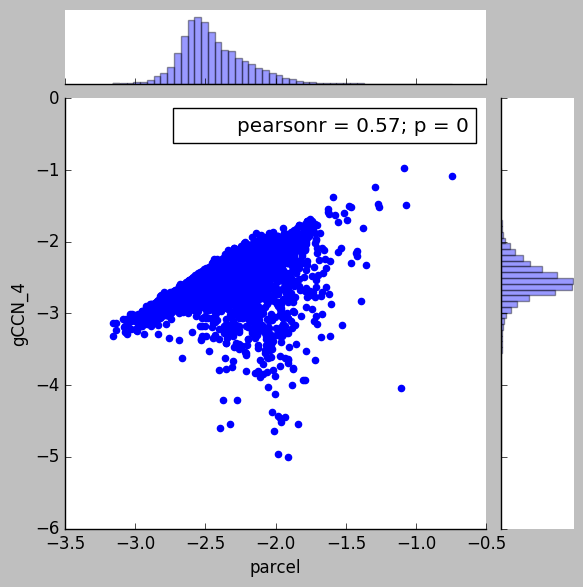

In [184]:
sns.jointplot('parcel', 'gCCN_4', ddd)

import sklearn.metrics as skm
skm.r2_score(sub['parcel'], sub['gCCN_4'])